# Libraries 

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Generating Data with 5 Classes

In [2]:
def generate_data(samples_per_class=180):
    np.random.seed(45)
    class1 = np.random.randn(samples_per_class, 2) + np.array([2, 2])
    class2 = np.random.randn(samples_per_class, 2) + np.array([6, 6])
    class3 = np.random.randn(samples_per_class, 2) + np.array([10, 2])
    class4 = np.random.randn(samples_per_class, 2) + np.array([2, 8])
    class5 = np.random.randn(samples_per_class, 2) + np.array([10, 8])

    X = np.vstack([class1, class2, class3, class4, class5])
    y = np.array([0]*samples_per_class + [1]*samples_per_class + [2]*samples_per_class +
                 [3]*samples_per_class + [4]*samples_per_class)
    return X, y

X, y = generate_data()

# Visualizing the Data 

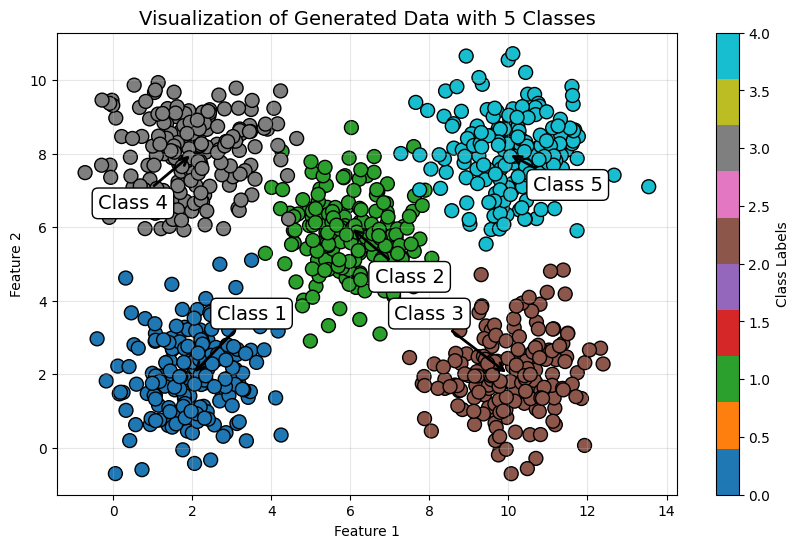

In [3]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap="tab10", s=100, edgecolor="k")

centers = [(2, 2), (6, 6), (10, 2), (2, 8), (10, 8)]
offsets = [(1.5, 1.5), (1.5, -1.5), (-2, 1.5), (-1.5, -1.5), (1.5, -1)]

for i, (center, offset) in enumerate(zip(centers, offsets)):
    plt.annotate(f'Class {i + 1}',
                 xy=center,
                 xytext=(center[0] + offset[0], center[1] + offset[1]),
                 arrowprops=dict(facecolor='black', arrowstyle='->', lw=2),
                 fontsize=14,
                 ha="center",
                 bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))

plt.title("Visualization of Generated Data with 5 Classes", fontsize=14)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(alpha=0.3)
plt.colorbar(scatter, label="Class Labels")
plt.show()

# Encoding the Labels 

In [4]:
encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(y.reshape(-1, 1))

# Spliting the Data 

In [5]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.4, random_state=45)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=45)

# Creating the Neural Networks 

In [6]:
class NeuralNet:
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size, lr):
        self.W1 = np.random.randn(input_size, hidden_size1)
        self.W2 = np.random.randn(hidden_size1, hidden_size2)
        self.W3 = np.random.randn(hidden_size2, hidden_size3)
        self.W4 = np.random.randn(hidden_size3, output_size)
        self.lr = lr

    def sigmoid(self, x, derivative=False):
        if derivative:
            return x * (1 - x)
        return 1 / (1 + np.exp(-x))

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def feed_forward(self, x):
        self.hidden_input1 = np.dot(x, self.W1)
        self.hidden_output1 = self.sigmoid(self.hidden_input1)

        self.hidden_input2 = np.dot(self.hidden_output1, self.W2)
        self.hidden_output2 = self.sigmoid(self.hidden_input2)

        self.hidden_input3 = np.dot(self.hidden_output2, self.W3)
        self.hidden_output3 = self.sigmoid(self.hidden_input3)

        self.output_input = np.dot(self.hidden_output3, self.W4)
        self.output = self.softmax(self.output_input)
        return self.output

    def backprop(self, x, y, output):
        output_delta = output - y 

        hidden_error3 = np.dot(output_delta, self.W4.T)
        hidden_delta3 = hidden_error3 * self.sigmoid(self.hidden_output3, derivative=True)

        hidden_error2 = np.dot(hidden_delta3, self.W3.T)
        hidden_delta2 = hidden_error2 * self.sigmoid(self.hidden_output2, derivative=True)

        hidden_error1 = np.dot(hidden_delta2, self.W2.T)
        hidden_delta1 = hidden_error1 * self.sigmoid(self.hidden_output1, derivative=True)

        self.W4 -= np.dot(self.hidden_output3.T, output_delta) * self.lr
        self.W3 -= np.dot(self.hidden_output2.T, hidden_delta3) * self.lr
        self.W2 -= np.dot(self.hidden_output1.T, hidden_delta2) * self.lr
        self.W1 -= np.dot(x.T, hidden_delta1) * self.lr

    def train(self, x, y):
        output = self.feed_forward(x)
        self.backprop(x, y, output)

# Training the Model

In [7]:
input_size = X_train.shape[1]
hidden_size1 = hidden_size2 = hidden_size3 = 22
output_size = y_train.shape[1]
lr = 0.0015
epochs = 1500

nn = NeuralNet(input_size, hidden_size1, hidden_size2, hidden_size3, output_size, lr)
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(epochs):
    nn.train(X_train, y_train)
    train_output = nn.feed_forward(X_train)
    val_output = nn.feed_forward(X_val)

    train_loss = -np.mean(np.sum(y_train * np.log(train_output + 1e-9), axis=1))
    val_loss = -np.mean(np.sum(y_val * np.log(val_output + 1e-9), axis=1))

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    train_accuracy = accuracy_score(np.argmax(y_train, axis=1), np.argmax(train_output, axis=1))
    val_accuracy = accuracy_score(np.argmax(y_val, axis=1), np.argmax(val_output, axis=1))
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, "
              f"Train Acc={train_accuracy*100:.2f}%, Val Acc={val_accuracy*100:.2f}%")

Epoch 0: Train Loss=2.7254, Val Loss=2.7894, Train Acc=10.37%, Val Acc=11.67%
Epoch 100: Train Loss=0.4121, Val Loss=0.4116, Train Acc=77.22%, Val Acc=76.67%
Epoch 200: Train Loss=0.3292, Val Loss=0.3280, Train Acc=78.52%, Val Acc=77.22%
Epoch 300: Train Loss=0.2942, Val Loss=0.2888, Train Acc=79.63%, Val Acc=77.78%
Epoch 400: Train Loss=0.2681, Val Loss=0.2610, Train Acc=89.81%, Val Acc=85.56%
Epoch 500: Train Loss=0.2919, Val Loss=0.2825, Train Acc=91.48%, Val Acc=90.00%
Epoch 600: Train Loss=0.2941, Val Loss=0.3221, Train Acc=84.63%, Val Acc=85.00%
Epoch 700: Train Loss=0.2971, Val Loss=0.3366, Train Acc=85.19%, Val Acc=83.89%
Epoch 800: Train Loss=0.3105, Val Loss=0.3564, Train Acc=83.89%, Val Acc=82.78%
Epoch 900: Train Loss=0.3269, Val Loss=0.3782, Train Acc=82.78%, Val Acc=81.67%
Epoch 1000: Train Loss=0.2617, Val Loss=0.2751, Train Acc=89.07%, Val Acc=86.67%
Epoch 1100: Train Loss=0.3262, Val Loss=0.3475, Train Acc=83.52%, Val Acc=83.33%
Epoch 1200: Train Loss=0.2992, Val Loss=

# Plotting the Loss & Accuracy

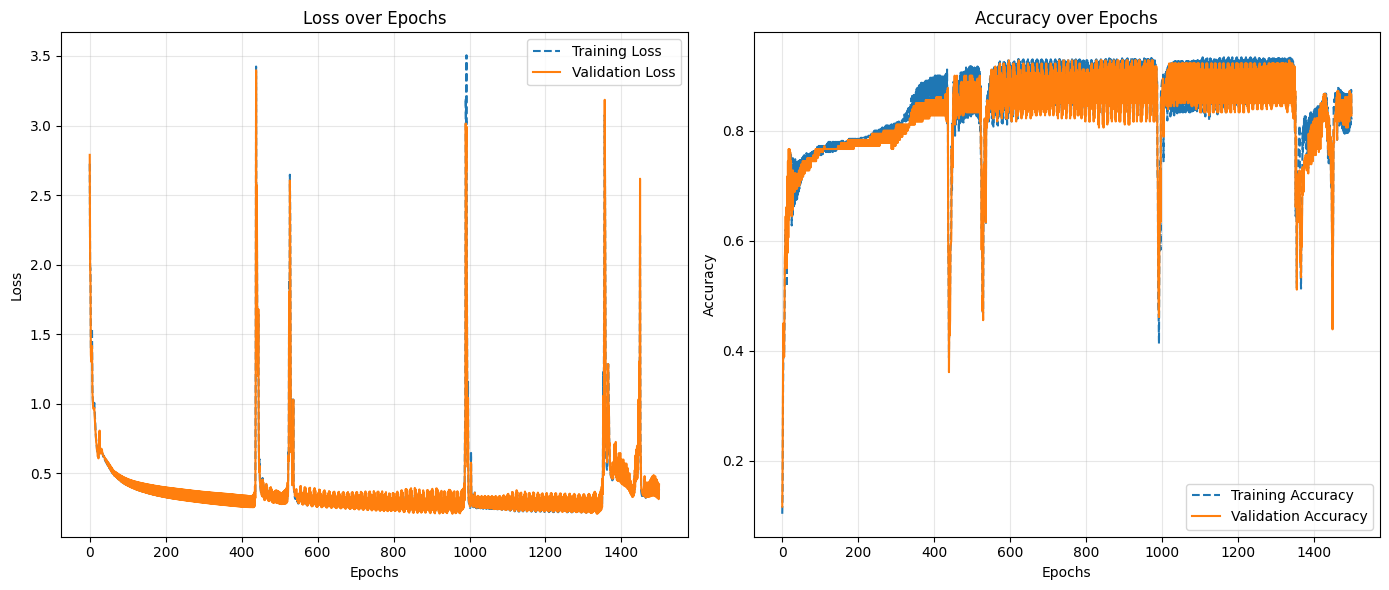

In [8]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss", linestyle='--')
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Training Accuracy", linestyle='--')
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Accuracy of TEST 

In [9]:
test_output = nn.feed_forward(X_test)
predicted_classes = np.argmax(test_output, axis=1)
actual_classes = np.argmax(y_test, axis=1)
test_accuracy = accuracy_score(actual_classes, predicted_classes)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Accuracy: 81.11%


# Visualization of the Predictions 

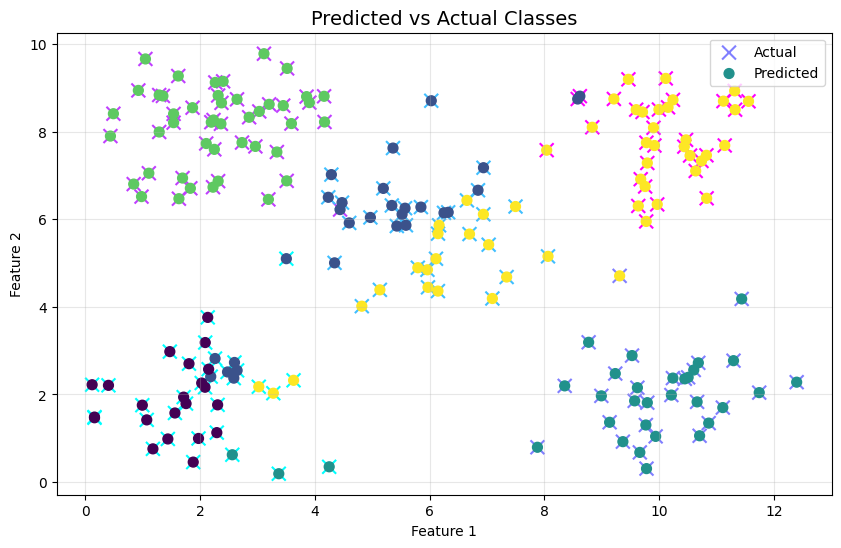

In [10]:
plt.figure(figsize=(10, 6))
plt.scatter(X_test[:, 0], X_test[:, 1], c=actual_classes, cmap='cool', s=100, marker='x', label='Actual')
plt.scatter(X_test[:, 0], X_test[:, 1], c=predicted_classes, cmap='viridis', s=50, marker='o', label='Predicted')
plt.title("Predicted vs Actual Classes", fontsize=14)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# The Decision Boundary 

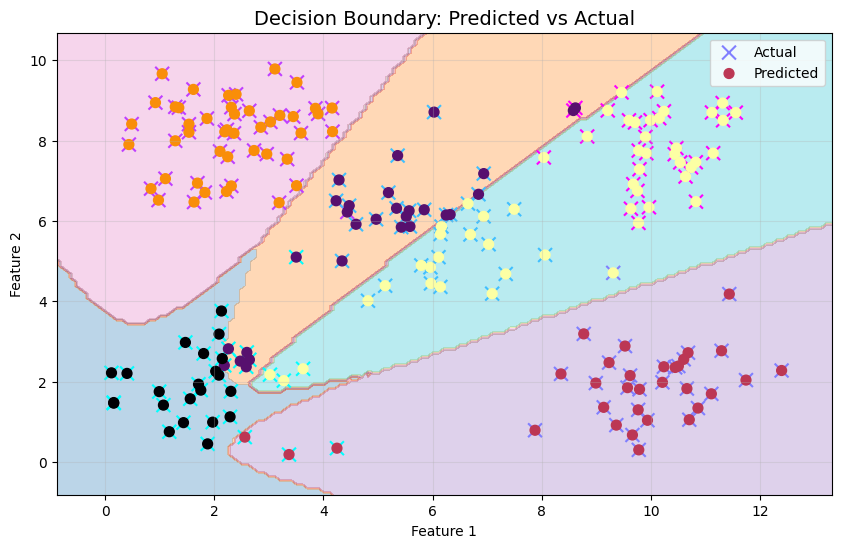

In [11]:
x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
Z = np.argmax(nn.feed_forward(np.c_[xx.ravel(), yy.ravel()]), axis=1)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='tab10')
plt.scatter(X_test[:, 0], X_test[:, 1], c=actual_classes, cmap='cool', s=100, marker='x', label='Actual')
plt.scatter(X_test[:, 0], X_test[:, 1], c=predicted_classes, cmap='inferno', s=50, marker='o', label='Predicted')
plt.title("Decision Boundary: Predicted vs Actual", fontsize=14)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# The Classification Report 

In [12]:
y_true = actual_classes
y_pred = predicted_classes

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=[f"Class {i}" for i in range(5)]))


Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      0.63      0.77        35
     Class 1       0.66      0.53      0.58        36
     Class 2       0.91      0.97      0.94        30
     Class 3       1.00      0.98      0.99        46
     Class 4       0.60      0.94      0.73        33

    accuracy                           0.81       180
   macro avg       0.83      0.81      0.80       180
weighted avg       0.84      0.81      0.81       180



# Visualizing the Confusion Matrix 

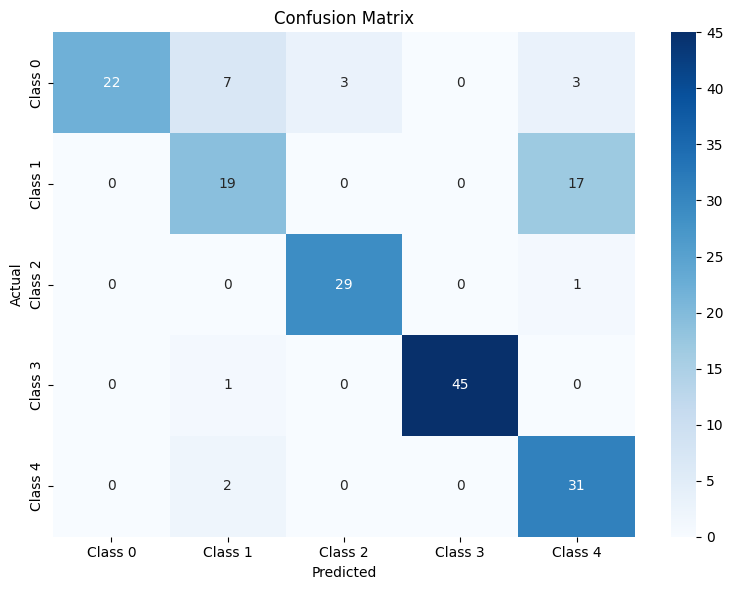

In [13]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_true, y_pred),
            annot=True, cmap="Blues", fmt="d",
            xticklabels=[f"Class {i}" for i in range(5)],
            yticklabels=[f"Class {i}" for i in range(5)])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Conclusion 

Justification for the modification: Multi-class classification was implemented by altering the algorithm to generate synthetic data with five distinct classes using make_classification.  After using OneHotEncoder to one-hot encode the class labels, the network is able to generate a probability distribution that encompasses all classes.  The neural network architecture had three hidden layers with ReLU activation to provide non-linearity, followed by an output layer with five neurons and softmax activation to ensure class probabilities.  given that multi-class classification problems are somewhat well-fitted by the categorical cross-entropy loss function.  During prediction, the class with the highest probability selected itself.  The model was evaluated using accuracy, a confusion matrix, and a classification report that included precision, recall, and F1-scores. Important Discoveries  In summary, the findings demonstrated that the model learned to classify inputs into the appropriate categories quite successfully, with a good level of accuracy and largely balanced performance across classes.  The confusion matrix and classification metrics showed that the model performed well for the majority of classes, despite the fact that there were a few misclassifications, most likely due to overlapping features or slight class imbalances in the synthetic dataset. Challenges and Learned Information: Throughout the implementation, a number of challenges surfaced.  Since poor choices might inhibit convergence, selecting appropriate weight initialization strategies and learning rates proved to be essential.  Debugging matrix dimensions during forward and backward passes was also a frequent problem, particularly with softmax and cross-entropy derivatives.  The necessity of regularizing, even in synthetic situations, was further highlighted by the overfitting danger. Potential Development or Further Research Projects: To enhance performance, a number of developments might be looked into.  Adding dropout or L2 regularization might assist avoid overfitting, even though experimenting with more sophisticated optimizers like Adam or RMSprop might enhance convergence.  Visualizing training curves, evaluating the model on real-world data, and employing hyperparameter adjustment may also yield deeper understanding and robustness.  All things considered, the project provided valuable experience in developing and refining a neural network for multi-class classification, as well as comprehensive analysis of implementation strategies and potential study fields.